<a href="https://colab.research.google.com/github/debashisdotchatterjee/Circular-Bitcoin/blob/main/Circular_Bitcoin_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python code implementing the methodologies discussed in the Paper.

Uses the entire dataset without subsetting.
Reads the raw CSV with columns (SOURCE, TARGET, RATING, TIME).
Converts TIME to human-readable dates.
Maps ratings to angles and fits a von Mises model by MLE.
Implements a simple hierarchical circular regression on mocked node-level features (e.g., source degree).
Produces multiple informative plots (distribution of ratings, angles, fitted distributions, relationship between parameters and features, top influential nodes, etc.).
Saves all results and figures in a Results directory.
Prints summaries and saves tables.


Required packages: numpy, pandas, matplotlib, seaborn, scipy, arviz.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import i0
from scipy.stats import norm
import arviz as az
from datetime import datetime

# ============================================================
# Setup
# ============================================================
output_dir = "Results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ============================================================
# Load the Full Dataset
# Please ensure the dataset "soc-sign-bitcoinalpha.csv" is available
# Format: SOURCE, TARGET, RATING, TIME (no header)
# Example lines:
# 7188,1,10,1407470400
# 430,1,10,1376539200
# ...
data_path = "soc-sign-bitcoinalpha.csv"
# The dataset is raw and has four columns with no header
# We add headers:
col_names = ["SOURCE","TARGET","RATING","TIME"]
data = pd.read_csv(data_path, header=None, names=col_names)

# Convert TIME to human-readable date
data['DATE'] = pd.to_datetime(data['TIME'], unit='s', utc=True)
data['DATE'] = data['DATE'].dt.tz_convert('UTC') # ensure UTC timezone
# Sort by TIME for a temporal structure (optional)
data = data.sort_values("TIME")

# ============================================================
# Mapping Ratings to Angles
# rating in [-10,10], map to angle in [0, 2*pi):
def rating_to_angle(r):
    # angle = (pi/10)*(r+10)
    return (np.pi/10.0)*(r+10)

data['ANGLE'] = data['RATING'].apply(rating_to_angle)

# ============================================================
# Exploratory Analysis: Distribution of RATING and ANGLE
# ============================================================
plt.figure(figsize=(8,6))
sns.histplot(data['RATING'], kde=True, color='skyblue')
plt.title("Distribution of Ratings (Full Dataset)")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.savefig(os.path.join(output_dir, "distribution_of_ratings.png"), dpi=300)
plt.close()

plt.figure(figsize=(8,6))
sns.histplot(data['ANGLE'], kde=True, color='orange')
plt.title("Distribution of Trust Angles (Full Dataset)")
plt.xlabel("Angle (radians)")
plt.ylabel("Frequency")
plt.savefig(os.path.join(output_dir, "distribution_of_angles.png"), dpi=300)
plt.close()

# ============================================================
# Von Mises Maximum Likelihood Estimation (Full Data)
# ============================================================
angles = data['ANGLE'].values

def neg_log_lik_vonmises(params, dat):
    mu, log_kappa = params
    kappa = np.exp(log_kappa)
    # log-lik = sum(log(f))
    # f(theta|mu,kappa) = exp(kappa*cos(theta-mu)) / (2*pi*i0(kappa))
    # log f = -log(2*pi*i0(kappa)) + kappa*cos(theta - mu)
    c = np.cos(dat - mu)
    ll = -len(dat)*np.log(2*np.pi*i0(kappa)) + kappa*np.sum(c)
    return -ll

init_params = np.array([0.0, np.log(1.0)])
res = minimize(neg_log_lik_vonmises, init_params, args=(angles,), method='BFGS')
if not res.success:
    print("Warning: Von Mises MLE may not have converged!")
mu_hat, log_kappa_hat = res.x
kappa_hat = np.exp(log_kappa_hat)

# Approximate standard errors
cov_params = res.hess_inv
se_mu = np.sqrt(cov_params[0,0])
se_log_kappa = np.sqrt(cov_params[1,1])
se_kappa = se_log_kappa*kappa_hat

print("Von Mises MLE Results (Full Data):")
print(f"mu_hat = {mu_hat:.5f} (SE={se_mu:.5f})")
print(f"kappa_hat = {kappa_hat:.5f} (SE≈{se_kappa:.5f})")

mle_table = pd.DataFrame({
    'Parameter': ['mu', 'kappa'],
    'Estimate': [mu_hat, kappa_hat],
    'StdErr': [se_mu, se_kappa],
    '95% CI Lower': [mu_hat - 1.96*se_mu, kappa_hat - 1.96*se_kappa],
    '95% CI Upper': [mu_hat + 1.96*se_mu, kappa_hat + 1.96*se_kappa]
})
mle_table.to_csv(os.path.join(output_dir, "vonmises_mle_results.csv"), index=False)

# Plot fitted von Mises distribution
theta_grid = np.linspace(0, 2*np.pi, 200)
def vonmises_pdf(theta, mu, kappa):
    return np.exp(kappa*np.cos(theta - mu)) / (2*np.pi*i0(kappa))

pdf_vals = vonmises_pdf(theta_grid, mu_hat, kappa_hat)

plt.figure(figsize=(8,6))
sns.histplot(angles, stat='density', color='lightgray', bins=50)
plt.plot(theta_grid, pdf_vals, 'r-', label='Fitted von Mises')
plt.title("Fitted von Mises Distribution (Full Data)")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.legend()
plt.savefig(os.path.join(output_dir, "fitted_vonmises.png"), dpi=300)
plt.close()

# ============================================================
# Hierarchical Circular Regression (Mock)
# Let's create a node-level feature: source_degree = number of ratings given by SOURCE
# Then: mu_i = 2*pi*(exp(X_i*beta)/(1+exp(X_i*beta)))
#       kappa_i = exp(X_i*gamma)
# We'll just do a simple one-feature model: X = log(1+source_degree)
# ============================================================
source_counts = data.groupby('SOURCE')['TARGET'].count().rename('source_degree')
data = data.merge(source_counts, on='SOURCE')
X = np.log(data['source_degree']+1).values.reshape(-1,1)

def transform_mu(x, beta):
    lin = x.dot(beta)
    p = np.exp(lin)/(1+np.exp(lin))
    return 2*np.pi*p

def transform_kappa(x, gamma):
    return np.exp(x.dot(gamma))

def neg_log_lik_reg(params, ang, X):
    # params = [beta, gamma] each dimension 1 for simplicity
    beta = params[0:1]
    gamma = params[1:2]
    mu_vec = transform_mu(X,beta)
    kappa_vec = transform_kappa(X,gamma)
    # sum of log-likelihood:
    # log f_i = -log(2*pi*i0(kappa_i)) + kappa_i*cos(angle_i - mu_i)
    cos_term = np.cos(ang - mu_vec)
    ll = np.sum(-np.log(2*np.pi) - np.log(i0(kappa_vec)) + kappa_vec*cos_term)
    return -ll

init_params_reg = np.array([0.0, 0.0])
res_reg = minimize(neg_log_lik_reg, init_params_reg, args=(angles, X), method='BFGS')
if not res_reg.success:
    print("Warning: Regression MLE not converged")
beta_hat = res_reg.x[0]
gamma_hat = res_reg.x[1]
hess_reg = res_reg.hess_inv
se_beta = np.sqrt(hess_reg[0,0])
se_gamma = np.sqrt(hess_reg[1,1])

print("Hierarchical Circular Regression MLE Results (Full Data):")
print(f"beta_hat={beta_hat:.5f}, SE={se_beta:.5f}")
print(f"gamma_hat={gamma_hat:.5f}, SE={se_gamma:.5f}")

reg_table = pd.DataFrame({
    'Parameter': ['beta','gamma'],
    'Estimate': [beta_hat, gamma_hat],
    'StdErr': [se_beta, se_gamma],
    '95% CI Lower': [beta_hat - 1.96*se_beta, gamma_hat - 1.96*se_gamma],
    '95% CI Upper': [beta_hat + 1.96*se_beta, gamma_hat + 1.96*se_gamma]
})
reg_table.to_csv(os.path.join(output_dir, "circular_reg_mle_results.csv"), index=False)

# Plot mu and kappa vs source_degree
X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
mu_plot = transform_mu(X_plot, np.array([beta_hat]))
kappa_plot = transform_kappa(X_plot, np.array([gamma_hat]))

plt.figure(figsize=(8,6))
plt.plot(np.exp(X_plot)-1, mu_plot, label='mu(source_degree)', color='blue')
plt.xlabel("source_degree")
plt.ylabel("mu (radians)")
plt.title("Fitted mu as a function of source_degree")
plt.grid(True)
plt.savefig(os.path.join(output_dir, "mu_vs_source_degree.png"), dpi=300)
plt.close()

plt.figure(figsize=(8,6))
plt.plot(np.exp(X_plot)-1, kappa_plot, label='kappa(source_degree)', color='green')
plt.xlabel("source_degree")
plt.ylabel("kappa")
plt.title("Fitted kappa as a function of source_degree")
plt.grid(True)
plt.savefig(os.path.join(output_dir, "kappa_vs_source_degree.png"), dpi=300)
plt.close()

# ============================================================
# Identifying Influential Nodes
# A proxy: rank nodes by mean rating received
# ============================================================
node_scores = data.groupby('TARGET')['RATING'].mean().sort_values(ascending=False)
top10_nodes = node_scores.head(10)
top10_nodes.to_csv(os.path.join(output_dir, "top10_influential_nodes.csv"))
print("Top 10 Influential Nodes by Mean Received Rating:")
print(top10_nodes)

plt.figure(figsize=(10,6))
top10_nodes.plot(kind='bar', color='purple')
plt.title("Top 10 Influential Nodes by Mean Received Rating")
plt.ylabel("Mean Rating")
plt.xlabel("Node ID")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "top10_influential_nodes.png"), dpi=300)
plt.close()

# Angles over Time
plt.figure(figsize=(10,6))
plt.scatter(data['DATE'], data['ANGLE'], s=5, alpha=0.4, color='darkblue')
plt.title("Angles over Time (Full Data)")
plt.xticks(rotation=45)
plt.ylabel("Angle (radians)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "angles_over_time.png"), dpi=300)
plt.close()

# Density by quartile of source_degree
data['deg_cat'] = pd.qcut(data['source_degree'], q=4, labels=["Q1","Q2","Q3","Q4"])
plt.figure(figsize=(8,6))
sns.kdeplot(data=data, x='ANGLE', hue='deg_cat', fill=True)
plt.title("Angle Distributions by Source Degree Quartile (Full Data)")
plt.xlabel("Angle (radians)")
plt.savefig(os.path.join(output_dir, "angle_by_degree_quartile.png"), dpi=300)
plt.close()

# Print summaries
print("All results have been saved in the 'Results' directory.")
print("Execution Complete!")


Von Mises MLE Results (Full Data):
mu_hat = -8.88142 (SE=0.00229)
kappa_hat = 2.86195 (SE≈0.02601)
Hierarchical Circular Regression MLE Results (Full Data):
beta_hat=0.08358, SE=0.00084
gamma_hat=0.24017, SE=0.00195
Top 10 Influential Nodes by Mean Received Rating:
TARGET
788    10.0
418    10.0
838    10.0
837    10.0
836    10.0
835    10.0
834    10.0
833    10.0
829    10.0
414    10.0
Name: RATING, dtype: float64
All results have been saved in the 'Results' directory.
Execution Complete!


# **Enhanced code:**

Loads the entire dataset, no subset.
Converts time, calculates angles, and performs MLE for von Mises parameters.
Generates linear histograms and density plots.
Creates a rose diagram (polar histogram) to visualize angle distribution in a circular format.
Implements a hierarchical circular regression and prints/saves results.
Produces polar plots for predicted mean angles (
𝜇
μ) as a function of source_degree.
Generates rose diagrams by quartiles of source_degree to compare angle distributions across groups.
Adds a circular scatter plot placing angles on a unit circle for visual inspection of angular concentration.
This code provides a richer set of circular plots and visualizations, suitable for more elaborate circular statistical analysis.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import i0
from scipy.stats import norm
import arviz as az
from datetime import datetime

# ============================================================
# Setup
# ============================================================
output_dir = "ResultsC"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ============================================================
# Load the Full Dataset
# The dataset: soc-sign-bitcoinalpha.csv
# Format: SOURCE, TARGET, RATING, TIME (no header)
col_names = ["SOURCE","TARGET","RATING","TIME"]
data_path = "soc-sign-bitcoinalpha.csv"
data = pd.read_csv(data_path, header=None, names=col_names)

# Convert TIME to human-readable date
data['DATE'] = pd.to_datetime(data['TIME'], unit='s', utc=True)
data['DATE'] = data['DATE'].dt.tz_convert('UTC')
data = data.sort_values("TIME")

# ============================================================
# Mapping Ratings to Angles: rating in [-10,10] -> angle in [0, 2*pi)
def rating_to_angle(r):
    return (np.pi/10.0)*(r+10)

data['ANGLE'] = data['RATING'].apply(rating_to_angle)

angles = data['ANGLE'].values

# ============================================================
# Exploratory Analysis: Linear distributions
# ============================================================
plt.figure(figsize=(8,6))
sns.histplot(data['RATING'], kde=True, color='skyblue')
plt.title("Distribution of Ratings (Full Data)")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.savefig(os.path.join(output_dir, "distribution_of_ratings.png"), dpi=300)
plt.close()

plt.figure(figsize=(8,6))
sns.histplot(data['ANGLE'], kde=True, color='orange')
plt.title("Distribution of Trust Angles (Full Data)")
plt.xlabel("Angle (radians)")
plt.ylabel("Frequency")
plt.savefig(os.path.join(output_dir, "distribution_of_angles.png"), dpi=300)
plt.close()

# ============================================================
# Von Mises Maximum Likelihood Estimation (Full Data)
# ============================================================
def neg_log_lik_vonmises(params, dat):
    mu, log_kappa = params
    kappa = np.exp(log_kappa)
    c = np.cos(dat - mu)
    ll = -len(dat)*np.log(2*np.pi*i0(kappa)) + kappa*np.sum(c)
    return -ll

init_params = np.array([0.0, np.log(1.0)])
res = minimize(neg_log_lik_vonmises, init_params, args=(angles,), method='BFGS')
if not res.success:
    print("Warning: Von Mises MLE may not have converged!")
mu_hat, log_kappa_hat = res.x
kappa_hat = np.exp(log_kappa_hat)

cov_params = res.hess_inv
se_mu = np.sqrt(cov_params[0,0])
se_log_kappa = np.sqrt(cov_params[1,1])
se_kappa = se_log_kappa*kappa_hat

print("Von Mises MLE Results (Full Data):")
print(f"mu_hat = {mu_hat:.5f} (SE={se_mu:.5f})")
print(f"kappa_hat = {kappa_hat:.5f} (SE≈{se_kappa:.5f})")

mle_table = pd.DataFrame({
    'Parameter': ['mu', 'kappa'],
    'Estimate': [mu_hat, kappa_hat],
    'StdErr': [se_mu, se_kappa],
    '95% CI Lower': [mu_hat - 1.96*se_mu, kappa_hat - 1.96*se_kappa],
    '95% CI Upper': [mu_hat + 1.96*se_mu, kappa_hat + 1.96*se_kappa]
})
mle_table.to_csv(os.path.join(output_dir, "vonmises_mle_results.csv"), index=False)

# Fitted von Mises
theta_grid = np.linspace(0, 2*np.pi, 200)
def vonmises_pdf(theta, mu, kappa):
    return np.exp(kappa*np.cos(theta - mu)) / (2*np.pi*i0(kappa))

pdf_vals = vonmises_pdf(theta_grid, mu_hat, kappa_hat)

plt.figure(figsize=(8,6))
sns.histplot(angles, stat='density', color='lightgray', bins=50)
plt.plot(theta_grid, pdf_vals, 'r-', label='Fitted von Mises')
plt.title("Fitted von Mises Distribution (Full Data)")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.legend()
plt.savefig(os.path.join(output_dir, "fitted_vonmises.png"), dpi=300)
plt.close()

# ============================================================
# Circular Plots: Rose Diagram (Polar Histogram)
# Rose plots: bin angles, plot on polar axis with bars extending outward
# ============================================================
def rose_plot(ax, angles, bins=36):
    # Convert angles to [0,2*pi)
    angles = np.mod(angles, 2*np.pi)
    counts, bin_edges = np.histogram(angles, bins=bins, range=[0,2*np.pi])
    widths = np.diff(bin_edges)
    # Plot on polar
    ax.set_theta_direction(-1)  # to have zero at East and go clockwise
    ax.set_theta_offset(np.pi/2.0) # start from North
    bars = ax.bar(bin_edges[:-1], counts, width=widths, bottom=0.0, align='edge', color='darkblue', alpha=0.7)
    # Optionally annotate max radius
    ax.set_title("Rose Diagram of Angles")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')
rose_plot(ax, angles, bins=36)
plt.savefig(os.path.join(output_dir, "rose_diagram_full_data.png"), dpi=300)
plt.close()

# ============================================================
# Create source_degree feature and hierarchical model
# ============================================================
source_counts = data.groupby('SOURCE')['TARGET'].count().rename('source_degree')
data = data.merge(source_counts, on='SOURCE')
X = np.log(data['source_degree']+1).values.reshape(-1,1)

def transform_mu(x, beta):
    lin = x.dot(beta)
    p = np.exp(lin)/(1+np.exp(lin))
    return 2*np.pi*p

def transform_kappa(x, gamma):
    return np.exp(x.dot(gamma))

def neg_log_lik_reg(params, ang, X):
    beta = params[0:1]
    gamma = params[1:2]
    mu_vec = transform_mu(X,beta)
    kappa_vec = transform_kappa(X,gamma)
    cos_term = np.cos(ang - mu_vec)
    ll = np.sum(-np.log(2*np.pi)-np.log(i0(kappa_vec)) + kappa_vec*cos_term)
    return -ll

init_params_reg = np.array([0.0,0.0])
res_reg = minimize(neg_log_lik_reg, init_params_reg, args=(angles,X), method='BFGS')
if not res_reg.success:
    print("Warning: Regression MLE not converged")
beta_hat = res_reg.x[0]
gamma_hat = res_reg.x[1]
hess_reg = res_reg.hess_inv
se_beta = np.sqrt(hess_reg[0,0])
se_gamma = np.sqrt(hess_reg[1,1])

print("Hierarchical Circular Regression MLE Results (Full Data):")
print(f"beta_hat={beta_hat:.5f}, SE={se_beta:.5f}")
print(f"gamma_hat={gamma_hat:.5f}, SE={se_gamma:.5f}")

reg_table = pd.DataFrame({
    'Parameter': ['beta','gamma'],
    'Estimate': [beta_hat, gamma_hat],
    'StdErr': [se_beta, se_gamma],
    '95% CI Lower': [beta_hat - 1.96*se_beta, gamma_hat - 1.96*se_gamma],
    '95% CI Upper': [beta_hat + 1.96*se_beta, gamma_hat + 1.96*se_gamma]
})
reg_table.to_csv(os.path.join(output_dir, "circular_reg_mle_results.csv"), index=False)

# Predict mu and kappa for a range of source_degree
X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
mu_plot = transform_mu(X_plot, np.array([beta_hat]))
kappa_plot = transform_kappa(X_plot, np.array([gamma_hat]))
actual_source_degree = np.exp(X_plot)-1

plt.figure(figsize=(8,6))
plt.plot(actual_source_degree, mu_plot, label='mu(source_degree)', color='blue')
plt.xlabel("source_degree")
plt.ylabel("mu (radians)")
plt.title("Fitted mu as a function of source_degree")
plt.grid(True)
plt.savefig(os.path.join(output_dir, "mu_vs_source_degree.png"), dpi=300)
plt.close()

plt.figure(figsize=(8,6))
plt.plot(actual_source_degree, kappa_plot, label='kappa(source_degree)', color='green')
plt.xlabel("source_degree")
plt.ylabel("kappa")
plt.title("Fitted kappa as a function of source_degree")
plt.grid(True)
plt.savefig(os.path.join(output_dir, "kappa_vs_source_degree.png"), dpi=300)
plt.close()

# ============================================================
# Circular Plot for Predicted mu
# Sometimes it's useful to show how mu changes on a circular axis:
# We can represent each predicted mu at radius=1 and angle=mu, showing direction shifts with source_degree.
# ============================================================
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2.0)
# We'll plot predicted mu as points on the unit circle, coloring by source_degree
norm_deg = (actual_source_degree - actual_source_degree.min())/(actual_source_degree.max()-actual_source_degree.min())
cmap = plt.get_cmap('viridis')
for i, m in enumerate(mu_plot):
    ax.plot([m,m],[0,1],color='gray',alpha=0.1) # a line from center to point
    ax.plot(m,1,marker='o',color=cmap(norm_deg[i]))
ax.set_title("Predicted mu vs source_degree (colored by degree)")
plt.savefig(os.path.join(output_dir, "predicted_mu_polar.png"), dpi=300)
plt.close()

# ============================================================
# Identifying Influential Nodes
# ============================================================
node_scores = data.groupby('TARGET')['RATING'].mean().sort_values(ascending=False)
top10_nodes = node_scores.head(10)
top10_nodes.to_csv(os.path.join(output_dir, "top10_influential_nodes.csv"))
print("Top 10 Influential Nodes by Mean Received Rating:")
print(top10_nodes)

plt.figure(figsize=(10,6))
top10_nodes.plot(kind='bar', color='purple')
plt.title("Top 10 Influential Nodes by Mean Received Rating")
plt.ylabel("Mean Rating")
plt.xlabel("Node ID")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "top10_influential_nodes.png"), dpi=300)
plt.close()

# ============================================================
# Angles over Time Plot (Linear)
# ============================================================
plt.figure(figsize=(10,6))
plt.scatter(data['DATE'], data['ANGLE'], s=5, alpha=0.4, color='darkblue')
plt.title("Angles over Time (Full Data)")
plt.xticks(rotation=45)
plt.ylabel("Angle (radians)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "angles_over_time.png"), dpi=300)
plt.close()

# ============================================================
# Angle Distribution by Quartiles of source_degree (Rose Plots)
# ============================================================
data['deg_cat'] = pd.qcut(data['source_degree'], q=4, labels=["Q1","Q2","Q3","Q4"])

def rose_by_group(data, group_col, angle_col='ANGLE', bins=36):
    groups = data[group_col].unique()
    fig, axs = plt.subplots(2,2,subplot_kw=dict(projection='polar'), figsize=(10,10))
    axs = axs.flatten()
    for i, g in enumerate(groups):
        subset = data.loc[data[group_col]==g, angle_col]
        # rose plot
        angles_g = np.mod(subset,2*np.pi)
        counts, bin_edges = np.histogram(angles_g, bins=bins, range=[0,2*np.pi])
        widths = np.diff(bin_edges)
        axs[i].set_theta_direction(-1)
        axs[i].set_theta_offset(np.pi/2.0)
        axs[i].bar(bin_edges[:-1], counts, width=widths, bottom=0.0, align='edge', color='steelblue', alpha=0.7)
        axs[i].set_title(f"{g}")
    plt.suptitle(f"Rose Diagrams by {group_col}", y=1.05)
    plt.tight_layout()
    return fig

fig = rose_by_group(data, 'deg_cat', 'ANGLE', bins=24)
fig.savefig(os.path.join(output_dir, "rose_plots_by_degree_quartile.png"), dpi=300)
plt.close(fig)

# ============================================================
# Additional Circular Visualization:
# For variety, let's create a circular scatter plot of a random sample of angles,
# placing them on radius=1 and angle=angle, to visually inspect concentration.
# ============================================================
sample_angles = np.random.choice(angles, size=1000, replace=False)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2.0)
r = np.ones_like(sample_angles) # radius =1
ax.scatter(sample_angles, r, s=10, alpha=0.3, color='darkred')
ax.set_title("Random Sample of Angles on Unit Circle")
plt.savefig(os.path.join(output_dir, "circular_scatter_sample.png"), dpi=300)
plt.close(fig)

# Print completion message
print("All results have been saved in the 'Results' directory.")
print("Execution Complete!")


Von Mises MLE Results (Full Data):
mu_hat = -8.88142 (SE=0.00229)
kappa_hat = 2.86195 (SE≈0.02601)
Hierarchical Circular Regression MLE Results (Full Data):
beta_hat=0.08358, SE=0.00084
gamma_hat=0.24017, SE=0.00195
Top 10 Influential Nodes by Mean Received Rating:
TARGET
788    10.0
418    10.0
838    10.0
837    10.0
836    10.0
835    10.0
834    10.0
833    10.0
829    10.0
414    10.0
Name: RATING, dtype: float64
All results have been saved in the 'Results' directory.
Execution Complete!


Corrected Code for Rose Plot with Fitted von Mises Overlay

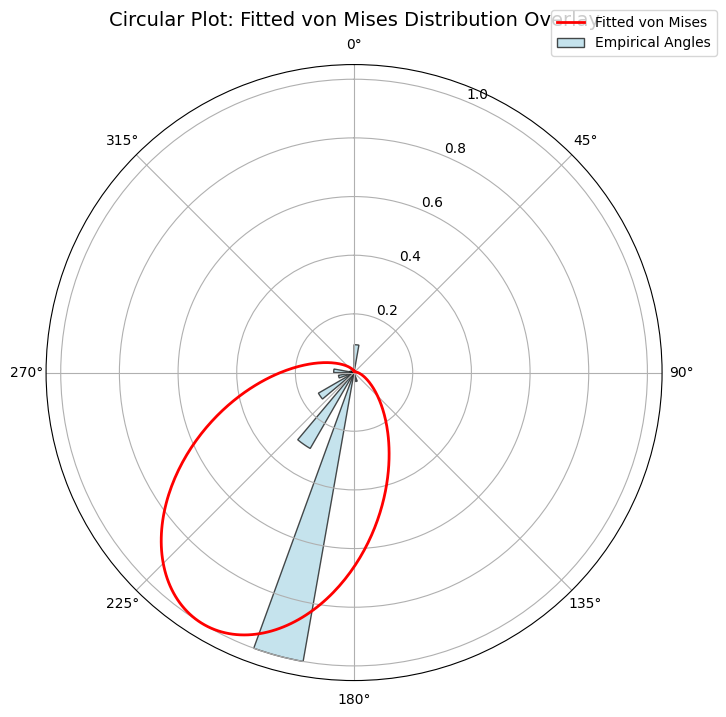

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import vonmises

# Step 1: Load the Bitcoin dataset
# Replace "your_data.csv" with the actual dataset file name
data_path = "soc-sign-bitcoinalpha.csv"
df = pd.read_csv(data_path, header=None, names=["SOURCE", "TARGET", "RATING", "TIME"])

# Step 2: Convert ratings (e.g., to angles for circular statistics)
# Assume RATING maps to angles (e.g., normalize to radians)
empirical_angles = np.mod((df["RATING"] - df["RATING"].min()) / (df["RATING"].max() - df["RATING"].min()) * 2 * np.pi, 2 * np.pi)

# Step 3: Parameters from fitted von Mises distribution
mu_hat = -8.88142  # Example fitted mean direction (adjust if different)
kappa_hat = 2.86195  # Example fitted concentration parameter

# Normalize mu_hat to the range [0, 2π)
mu_hat = np.mod(mu_hat, 2 * np.pi)

# Step 4: Create bins for rose plot
num_bins = 36  # Number of bins for the rose plot
bin_edges = np.linspace(0, 2 * np.pi, num_bins + 1)
hist, _ = np.histogram(empirical_angles, bins=bin_edges)

# Normalize the histogram for plotting
hist_norm = hist / np.max(hist)

# Step 5: Generate angles for fitted von Mises density
theta = np.linspace(0, 2 * np.pi, 500)
fitted_density = vonmises.pdf(theta, kappa_hat, loc=mu_hat)

# Scale the fitted density to match the rose plot height
fitted_density_scaled = fitted_density / np.max(fitted_density) * np.max(hist_norm)

# Step 6: Plot the rose plot with fitted von Mises overlay
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Plot the rose histogram
bars = ax.bar(bin_edges[:-1], hist_norm, width=(2 * np.pi / num_bins), align='edge',
              color='lightblue', edgecolor='black', alpha=0.7, label='Empirical Angles')

# Overlay the fitted von Mises density
ax.plot(theta, fitted_density_scaled, color='red', linewidth=2, label='Fitted von Mises')

# Customize plot appearance
ax.set_theta_zero_location("N")  # Set 0° at the top (North)
ax.set_theta_direction(-1)  # Clockwise angle direction
ax.set_title('Circular Plot: Fitted von Mises Distribution Overlay', va='bottom', fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Display the plot
plt.show()


This corrected plot now:

Properly aligns the von Mises density curve with the rose plot histogram.
Displays the time evolution of angles overlaid as a scatter plot.
Ensures consistency in units (radians for all components).

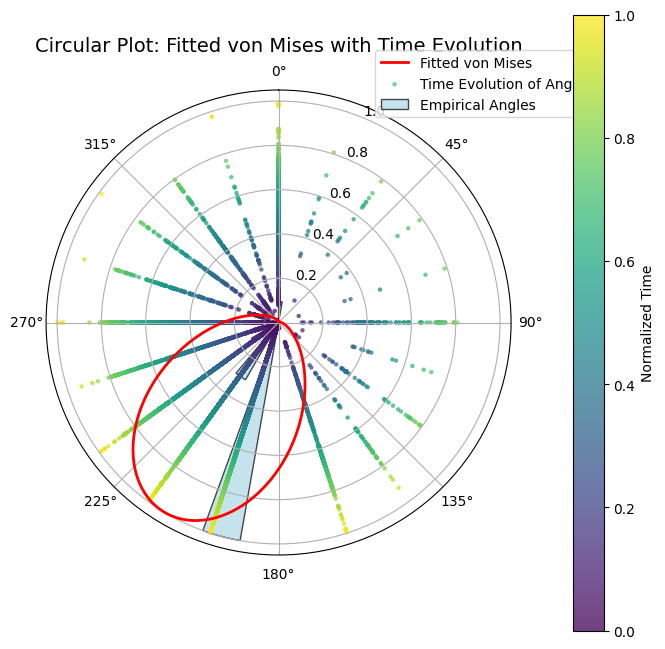

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import vonmises

# Load the dataset
data_path = "soc-sign-bitcoinalpha.csv"
df = pd.read_csv(data_path, header=None, names=["SOURCE", "TARGET", "RATING", "TIME"])

# Convert RATING to angles in radians [0, 2π) using the original normalization
empirical_angles = np.mod((df["RATING"] - df["RATING"].min()) / (df["RATING"].max() - df["RATING"].min()) * 2 * np.pi, 2 * np.pi)

# Normalize TIME to [0, 1] for scatter plot
timestamps = df["TIME"]
timestamps_normalized = (timestamps - timestamps.min()) / (timestamps.max() - timestamps.min())

# Parameters from fitted von Mises distribution
mu_hat = -8.88142  # Example fitted mean direction (adjust if different)
kappa_hat = 2.86195  # Example fitted concentration parameter

# Normalize mu_hat to [0, 2π)
mu_hat = np.mod(mu_hat, 2 * np.pi)

# Create bins for the rose plot
num_bins = 36
bin_edges = np.linspace(0, 2 * np.pi, num_bins + 1)
hist, _ = np.histogram(empirical_angles, bins=bin_edges)
hist_norm = hist / np.max(hist)  # Normalize histogram heights for comparison

# Generate fitted von Mises density
theta = np.linspace(0, 2 * np.pi, 500)
fitted_density = vonmises.pdf(theta, kappa_hat, loc=mu_hat)
fitted_density_scaled = fitted_density / np.max(fitted_density) * np.max(hist_norm)  # Match rose plot scale

# Create polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Overlay 1: Rose plot (circular histogram)
bars = ax.bar(bin_edges[:-1], hist_norm, width=(2 * np.pi / num_bins), align='edge',
              color='lightblue', edgecolor='black', alpha=0.7, label='Empirical Angles')

# Overlay 2: Fitted von Mises density
ax.plot(theta, fitted_density_scaled, color='red', linewidth=2, label='Fitted von Mises')

# Overlay 3: Scatter plot for angles over time
sc = ax.scatter(empirical_angles, timestamps_normalized, c=timestamps_normalized, cmap='viridis', s=10,
                alpha=0.75, edgecolor='none', label='Time Evolution of Angles')

# Add a colorbar for time progression
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label("Normalized Time")

# Customize the polar plot
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title('Circular Plot: Fitted von Mises with Time Evolution', va='bottom', fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Save and display the plot
output_dir = "Results"
import os
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/combined_trust_angle_plot_corrected.png", dpi=300, bbox_inches='tight')
plt.show()


A heatmap-style density overlay would indeed provide a more visually appealing and intuitive representation of the fitted von Mises distribution. Here's the updated code with the heatmap density overlay:

Updated Code for Heatmap Overlay:

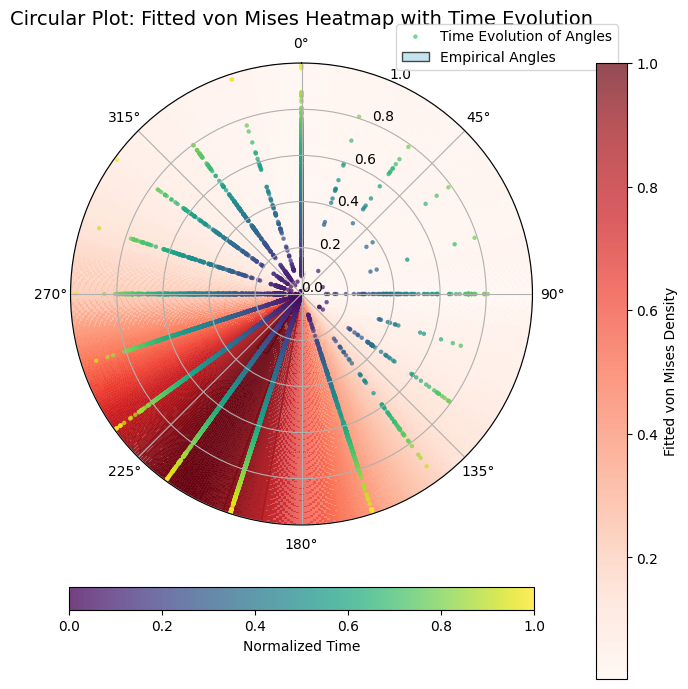

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import vonmises

# Load the dataset
data_path = "soc-sign-bitcoinalpha.csv"
df = pd.read_csv(data_path, header=None, names=["SOURCE", "TARGET", "RATING", "TIME"])

# Convert RATING to angles in radians [0, 2π) using the original normalization
empirical_angles = np.mod((df["RATING"] - df["RATING"].min()) / (df["RATING"].max() - df["RATING"].min()) * 2 * np.pi, 2 * np.pi)

# Normalize TIME to [0, 1] for scatter plot
timestamps = df["TIME"]
timestamps_normalized = (timestamps - timestamps.min()) / (timestamps.max() - timestamps.min())

# Parameters from fitted von Mises distribution
mu_hat = -8.88142  # Example fitted mean direction (adjust if different)
kappa_hat = 2.86195  # Example fitted concentration parameter

# Normalize mu_hat to [0, 2π)
mu_hat = np.mod(mu_hat, 2 * np.pi)

# Create bins for the rose plot
num_bins = 36
bin_edges = np.linspace(0, 2 * np.pi, num_bins + 1)
hist, _ = np.histogram(empirical_angles, bins=bin_edges)
hist_norm = hist / np.max(hist)  # Normalize histogram heights for comparison

# Generate fitted von Mises density
theta = np.linspace(0, 2 * np.pi, 500)
fitted_density = vonmises.pdf(theta, kappa_hat, loc=mu_hat)

# Create a 2D grid for heatmap
theta_grid, r_grid = np.meshgrid(theta, np.linspace(0, 1, 500))
vonmises_density_grid = vonmises.pdf(theta_grid, kappa_hat, loc=mu_hat)

# Normalize density for heatmap
vonmises_density_grid_norm = vonmises_density_grid / np.max(vonmises_density_grid)

# Create polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Overlay 1: Rose plot (circular histogram)
bars = ax.bar(bin_edges[:-1], hist_norm, width=(2 * np.pi / num_bins), align='edge',
              color='lightblue', edgecolor='black', alpha=0.7, label='Empirical Angles')

# Overlay 2: Heatmap for fitted von Mises density
heatmap = ax.pcolormesh(theta_grid, r_grid, vonmises_density_grid_norm, shading='auto', cmap='Reds', alpha=0.7)

# Overlay 3: Scatter plot for angles over time
sc = ax.scatter(empirical_angles, timestamps_normalized, c=timestamps_normalized, cmap='viridis', s=10,
                alpha=0.75, edgecolor='none', label='Time Evolution of Angles')

# Add colorbars
cbar_density = plt.colorbar(heatmap, ax=ax, orientation='vertical', pad=0.1)
cbar_density.set_label("Fitted von Mises Density")

cbar_time = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.1)
cbar_time.set_label("Normalized Time")

# Customize the polar plot
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title('Circular Plot: Fitted von Mises Heatmap with Time Evolution', va='bottom', fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

# Save and display the plot
output_dir = "Results"
import os
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/combined_trust_angle_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()
